In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw""
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| echo: false
#| eval: false
#| output: false
#| fig-align: center
using TikzPictures

tp = TikzPicture(L"""
\matrix 
{    \draw[line width=.3mm,->-=.5,bicolor={red}{blue}] (-1.5,0)  --  (1.5,0) node[midway,above,color=black]{$\displaystyle(k_0,\mathbf{k})$}; &
    \node{$=$}; &
    \node {$\displaystyle\frac{\im}{k_0-\sqrt{\mathbf{k}^2+m_{\textcolor{red}{1}, \textcolor{blue}{2}}^2}+\im 0},$}; \\
  };"""
, options="thick, transform shape",preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings}\\input{../latexmacros.tex}\\usepackage{xcolor}")
save(PDF("./tikz/propagator.pdf"), tp)
save(TEX("./tikz/propagator"; limit_to=:picture), tp)
tp

In [3]:
#| echo: false
#| eval: false
#| output: false 
#| fig-align: center 
using TikzPictures

tp = TikzPicture(L"""


\matrix 
{    \graph[nodes=coordinate, empty nodes,spring layout,horizontal=i1 to o1,anchor node=a] 
{
  {i1} --[->-=.5,thick,"$\displaystyle \mathbf{k}$" font=\large,red]  a[circle,fill,scale=.6] --[->-=.6,thick,"$\displaystyle \mathbf{k'}$" {font=\large},red] o1;
  i2 --[->-=.5,thick,"$\displaystyle -\mathbf{k}$" {font=\large, below,yshift=-5},blue]  a --[->-=.6,thick,"$\displaystyle  - \mathbf{k'}$"  {font=\large, below,yshift=-5,xshift=-5},blue] o2;
};
&
    \node{$=$}; &
    \node {$\displaystyle\im V(\mathbf{k},\mathbf{k'}).$}; \\
  };"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")
save(PDF("./tikz/vertex.pdf"), tp)
save(TEX("./tikz/vertex"; limit_to=:picture), tp)
tp

In [4]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
\matrix{
      \node{$\ampl_\text{EFT}$};&
      \node{$=$};&
      \graph[nodes=coordinate, empty nodes,spring layout,horizontal=i1 to o1,anchor node=a]{
            {i1} --[->-=.5,thick,blue]  a[circle,fill,scale=.6]  --[->-=.6,thick,blue] o1;
            i2 --[->-=.5,thick,red]  a --[->-=.6,thick,red] o2;};&
      \node{$+$}; &
      \graph[nodes=coordinate, empty nodes,spring layout,horizontal=a to d,anchor node=a]{
            {i1} --[->-=.5,thick,blue]  a[circle,fill,scale=.6] --[->-=.6,thick,blue,bend left=90] d[circle,fill,scale=.6] --[->-=.6,thick,red] o1;
            i2 --[->-=.5,thick,red]  a --[->-=.6,thick,red,bend right=90] d --[->-=.6,thick,blue] o2;};&
      \node{$+$}; &
      \graph[nodes=coordinate, empty nodes,spring layout,horizontal=a to d,horizontal=i1 to o1,anchor node=a]{
            {i1} --[->-=.5,thick,blue]  a[circle,fill,scale=.6] --[->-=.6,thick,blue,bend left=90] d[circle,fill,scale=.6]--[->-=.6,thick,blue,bend left=90] c[circle,fill,scale=.6] --[->-=.6,thick,blue] o1;
            i2 --[->-=.5,thick,red]  a --[->-=.6,thick,red,bend right=90] d--[->-=.6,thick,red,bend right=90] c --[->-=.6,thick,red] o2;};&
      \node{$+$}; &
      \graph[nodes=coordinate, empty nodes,spring layout,horizontal=i1 to o1,horizontal=a to b,anchor node=a]{
            {i1} --[->-=.5,thick,red]  a[circle,fill,scale=.6] --[->-=.6,thick,blue,bend left=90] b[circle,fill,scale=.6] --[->-=.6,thick,blue,bend left=90] c[circle,fill,scale=.6] --[->-=.6,thick,blue,bend left=90] d[circle,fill,scale=.6] --[->-=.6,thick,red] o1;
            i2 --[->-=.5,thick,blue]  a --[->-=.6,thick,red,bend right=90] b --[->-=.6,thick,red,bend right=90] c --[->-=.6,thick,red,bend right=90] d --[->-=.6,thick,blue] o2;};&
      \node{$+$};&
      \node{$\cdots$};
      \\
};"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(PDF("./tikz/eftampl.pdf"), tp)
save(TEX("./tikz/eftampl"; limit_to=:picture), tp)
tp

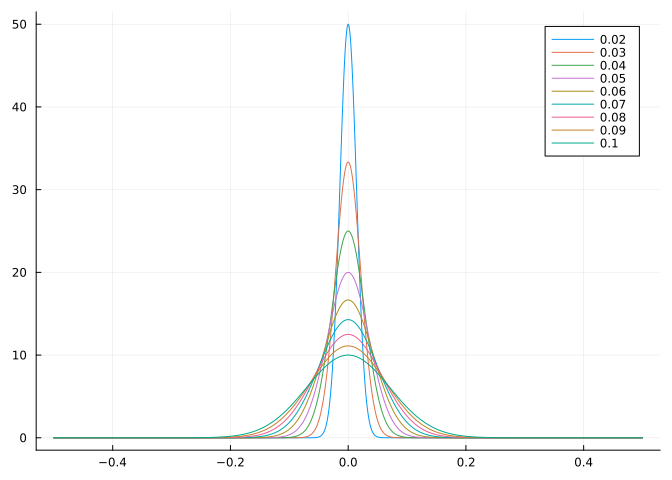

In [5]:
#| echo: false
#| label: fig-gaussian
#| fig-cap: Sharpening gaussian
#| column: margin
using Plots

function delta(x)
    if abs(x)<1e-3
        return 1
    else
        return 0
    end
end

function gauss(x)
    return exp(-x^2)
end

function sharpen(f,eps,power)
    return x->f(x/eps^power)/eps^power
end

epss=0.02:0.01:0.1



p=plot([sharpen(gauss,eps,1) for eps in epss], -0.5,0.5,label=epss')

In [6]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
     \graph[ empty nodes,spring layout,node distance=20mm,horizontal=p1 to p4 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1[as=$\mu$] --[photon,thick,postaction={draw,->, 
     shorten >=5mm, shorten <=5mm, 
     decoration={sl,raise=3mm},decorate},"$\ell$" {auto=left ,inner sep=4mm}]  p4[as=$\nu$];
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/photonprop"; limit_to=:picture), tp)
save(PDF("./tikz/photonprop"), tp)
save(SVG("./tikz/photonprop"), tp)
tp

In [7]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
     \graph[ empty nodes,spring layout,node distance=12mm,horizontal=p1 to p4 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1[as=$\mu$] --[photon,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$k$" {auto=left ,inner sep=4mm}]  p4[fill = red!20, draw = black, ultra thick, circle,scale=.6];
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/extphoton"; limit_to=:picture), tp)
save(SVG("./tikz/extphoton"), tp)
tp

In [8]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
     \graph[ empty nodes,spring layout,node distance=20mm,horizontal=p1 to p4 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1 --[thick,->-=.55,postaction={draw,->, 
     shorten >=5mm, shorten <=5mm, 
     decoration={sl,raise=3mm},decorate},"$k$" above=3mm]  p4;
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes,arrows.meta}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/scalarprop"; limit_to=:picture), tp)
save(SVG("./tikz/scalarprop"), tp)
tp

In [9]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
     \graph[ empty nodes,spring layout,node distance=12mm,horizontal=p1 to p4 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1 --[thick,->-=.55,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$k$" above=3mm]  p4[fill = red!20, draw = black, ultra thick, circle,scale=.6];
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes,arrows.meta}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/extscalar"; limit_to=:picture), tp)
save(SVG("./tikz/extscalar"), tp)
tp

In [10]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
     \graph[ empty nodes,spring layout,node distance=15mm,horizontal=p1 to p3 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1 --[thick,->-=.55]  p4[fill = red!20, draw = black, ultra thick, circle,scale=.6] --[thick,->-=.55] p3;
     q1[as=$\mu$] --[thick,photon]  p4 --[thick,photon] q3[as=$\nu$];
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes,arrows.meta}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/seagull"; limit_to=:picture), tp)
save(SVG("./tikz/seagull"), tp)
tp

In [11]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L""" 
     \graph[ empty nodes,spring layout,node distance=15mm,horizontal=q3 to p4 ,random seed=4,anchor node=a,anchor at={(0,0.5)}] 
{
  p1 --[thick,->-=.55,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$k_i$" {auto=left ,inner sep=3mm}]  p4[fill = red!20, draw = black, ultra thick, circle,scale=.6] --[thick,->-=.55,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$k_i'$" {auto=left ,inner sep=3mm}] p3;
    q3[as=$\nu$] --[thick,photon,] p4;
};

"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes,arrows.meta}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/cubic"; limit_to=:picture), tp)
save(SVG("./tikz/cubic"), tp)
tp

In [12]:
#| echo: false
#| output: false
#| eval: false
using TikzPictures

tp = TikzPicture(L"""
\matrix{
      \node{$\displaystyle \im\redamp[(0)]{\semom[1]-\Half[\tm],\semom[2]+\Half[\tm]}{\semom[1]+\Half[\tm],\semom[2]-\Half[\tm]}$};&
      \node{$=$};&
     \graph[nodes=coordinate, empty nodes,spring layout,node distance=20mm,vertical=p1 to p2,random seed=1,anchor node=a,anchor at={(0,0.5)}] 
{
  p1 --[->-=.5,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm,mirror},decorate},"$\semom[1]-\Half[\tm]$" {auto=right ,inner sep=4mm}]  a[fill = red!20, draw = black, ultra thick, circle,scale=.6] --[->-=.7,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm,mirror},decorate},"$\semom[1]+\Half[\tm]$" {auto=right ,inner sep=4mm}] p4;
  a -- [photon,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$q$" {auto=left ,inner sep=4mm}]] b[fill = red!20, draw = black, ultra thick, circle,scale=.6];
  p2 --[->-=.5,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$\semom[2]+\Half[\tm]$" {auto=left ,inner sep=4mm}]]  b --[->-=.7,thick,postaction={draw,->, 
     shorten >=3mm, shorten <=3mm, 
     decoration={sl,raise=3mm},decorate},"$ \semom[2]-\Half[\tm]$" {auto=left ,inner sep=4mm}]] p3;
};\\
};"""
,preamble="\\usepackage{adjustbox}\\usepackage{amsmath}\\usetikzlibrary{decorations.markings,graphs,decorations.pathmorphing,graphdrawing,quotes,arrows.meta}\\usegdlibrary{trees,force}\\input{../latexmacros.tex}")

save(TEX("./tikz/treelevelsqed"; limit_to=:picture), tp)
save(PDF("./tikz/treelevelsqed"), tp)
save(SVG("./tikz/treelevelsqed"), tp)
tp

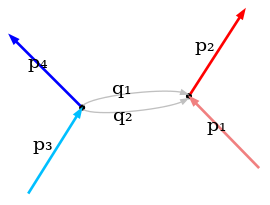

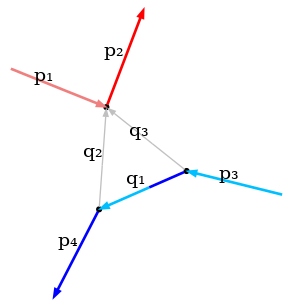

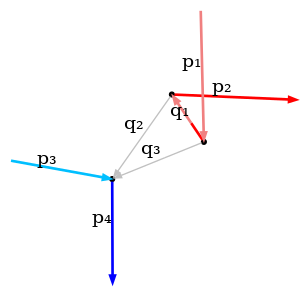

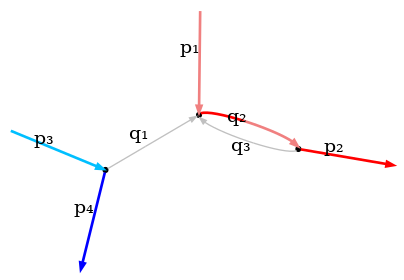

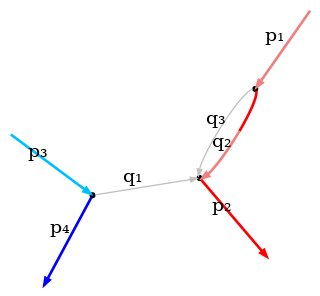

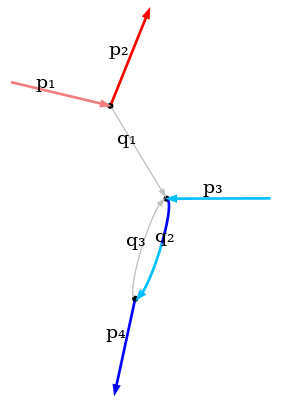

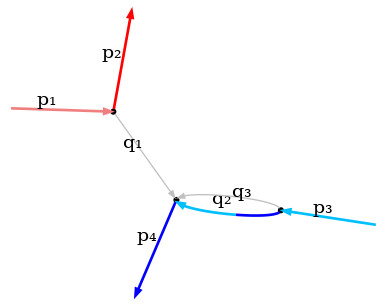

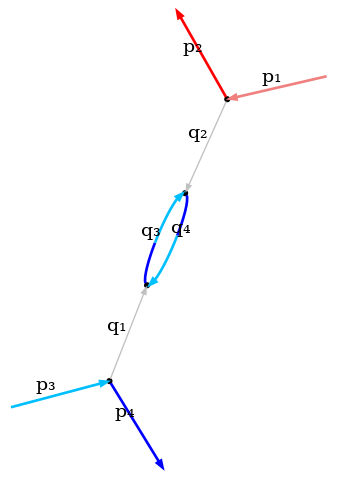

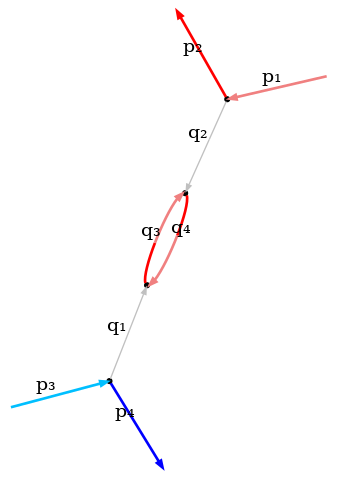

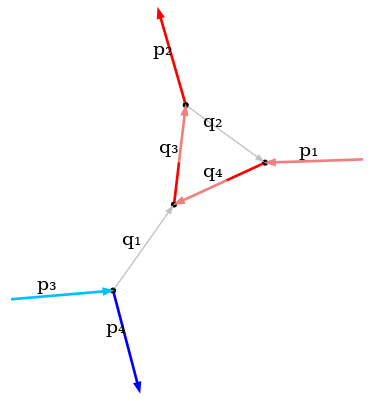

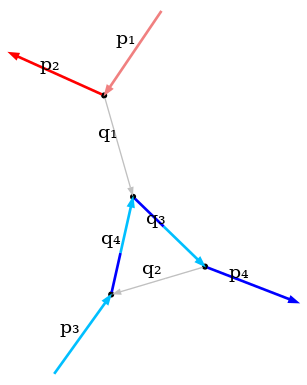

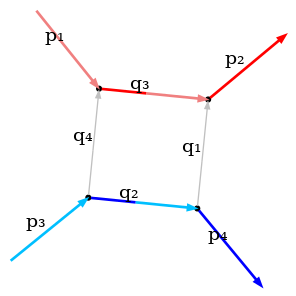

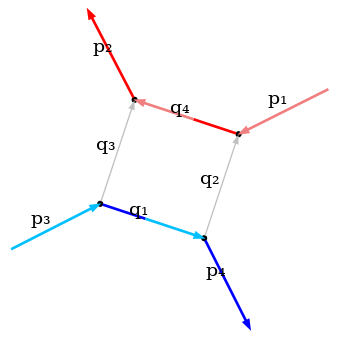

In [13]:
#| layout-ncol: 3
using Images
using QFT
using QFT.Diagrams
using QFT.FieldGraphs
using QFT.Fields
import  Catlab.Graphics.Graphviz: run_graphviz
include("SQED.jl")
diags=include("QGRAFout/julia/1lSQED.jl")


qDiags=[qDiagram(;diag...) for diag in diags]
grafs=(x -> x.g).(qDiags)

for (i,graf) in enumerate(grafs)
    open("./png/diag$i.png";create=true,write=true) do io
    run_graphviz(io,to_graphviz(graf),format="png")
    end
    display(Images.load("./png/diag$i.png"))  
end
nothing

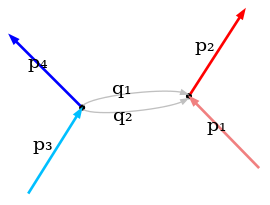

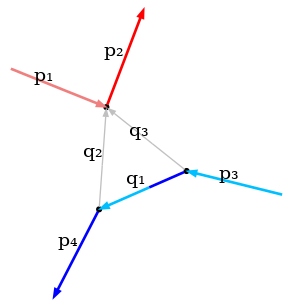

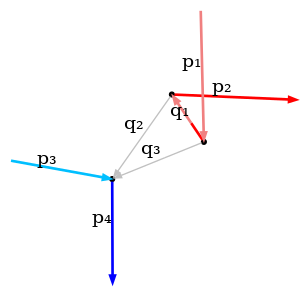

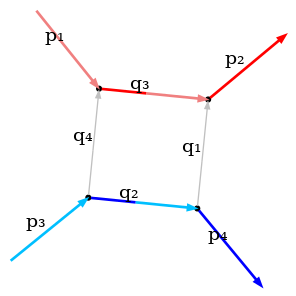

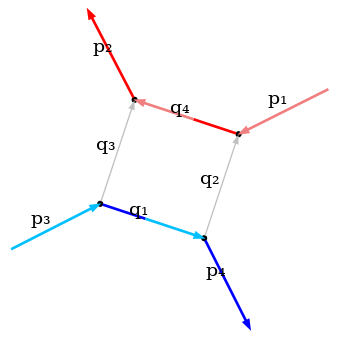

In [14]:
#| layout-ncol: 5
using Logging
Logging.disable_logging(Logging.Info)
function scaleless(g::AbstractFieldGraph)
  cycles =cycle_basis(g)
  isscaleless=false
  for c in cycles
    hs= collect(Iterators.flatten(half_edges.(Ref(g),c)))
    fields=unique!(typeof.(field.(Ref(g),hs)))
    if Bool(Phi1 in fields) ⊻  Bool(Phi2 in fields)
      isscaleless=true
    end
  end
  return isscaleless
end

noscalelessdiags=qDiags[.!scaleless.(grafs)]
classicaldiags=noscalelessdiags[2:end]
for (i,d) in enumerate(classicaldiags)
  d.ID=i
end
for (i,graf) in enumerate(grafs[.!scaleless.(grafs)])
    open("./png/diagscaleless$i.png";create=true,write=true) do io
    run_graphviz(io,to_graphviz(graf),format="png")
    end
    display(Images.load("./png/diagscaleless$i.png"))  
end
nothing

In [15]:
#| output: false
#| eval: false
#| code-overflow: wrap
function feynmanRule(mime::MIME"text/FORM",p,f1::Photon,f2::Photon)
  momen = repr(mime,p.symbol)
  indx1 = repr(mime,index(f1))
  indx2 = repr(mime,index(f2))
  "_i* prop(-1,0,$momen)*d_($indx1,$indx2)"
end

@symmetric function feynmanRule(mime::MIME"text/FORM",p,[f1::Phi1,f2::Phi1c])
  momen = repr(mime,p.symbol)
  "_i* prop(-1,1,$momen)"
end

@symmetric function feynmanRule(mime::MIME"text/FORM",p,[f1::Phi2,f2::Phi2c])
  momen = repr(mime,p.symbol)

  "_i* prop(-1,2,$momen)"
end

@symmetric function feynmanRule(mime::MIME"text/FORM",[(pᵩ₁,a)::Tuple{Any,ScalarField{S}},
            (pᵩ₂,b)::Tuple{Any,AdjointField{ScalarField{S}}},
            (pᵧ,γ)::Tuple{Any,Photon}]) where {S}
  p1 = repr(mime,pᵩ₁(index(γ)))
  p2 = repr(mime,pᵩ₂(index(γ)))
  q = repr(mime,charge(a))
  "_i*e*$q*($p2-$p1)"
end

@symmetric function feynmanRule(mime::MIME"text/FORM",[(pᵧ₁,γ₁)::Tuple{Any,Photon},
            (pᵧ₂,γ₂)::Tuple{Any,Photon},(pᵩ₂,b)::Tuple{Any,AdjointField{ScalarField{S}}},
            (pᵩ₁,a)::Tuple{Any,ScalarField{S}}]) where {S}    
  mu = repr(mime,index(γ₁))
  nu = repr(mime,index(γ₂)) 
  q = repr(mime,charge(a))
  "2*_i*$q^2*e^2*d_($mu,$nu)"
end 

In [16]:
#| echo: false
#| output: false
#| eval: false


open("diags.frm";create=true,write=true) do io
  write(io,"""
  Symbol x;
Auto V p;
Auto V p;
Auto V q;
Auto S m;
S e;
Auto S Q;
Auto I nu;
CF prop;
CF inv;
  """)
  for qd in classicaldiags
    toform(io,qd)
    println(io,"")
  end
end;

In [17]:
#| echo: fenced
toform(stdout,classicaldiags[3])

*--#[d3l1:


L [d3l1|o.3.4|i.3.4|i|o|] = 1*i_* prop(-1,0,q1)*d_(nu1,nu2)*i_* prop(-1,1,q2)*i_* prop(-1,2,q3)*i_* prop(-1,0,q4)*d_(nu7,nu8)*i_*e*qch1*(q2(nu1)-p4(nu1))*i_*e*qch2*(q3(nu2)-p2(nu2))*i_*e*qch1*(p3(nu7)-q2(nu7))*i_*e*qch2*(p1(nu8)-q3(nu8));
#procedure momentumRouting
Id q2 = p3 + -q4;
Id p1 = p2 + p4 + -p3;
Id q1 = p3 + -p4 + -q4;
Id q3 = p2 + p4 + q4 + -p3;

Id q4= l1;
#endprocedure
*--#]d3l1:
